Load modules

In [11]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np

Hyperparameters

In [12]:
D = 1*28*28    # MNIST image shape : (1, 28, 28)
P = 3    # output dimmension 
L = 3    # depth of network
UNIT = 64    # unit of hidden layers of network
N_EPOCH = 5
LR = 1e-4    # learning rate
BATCH_SIZE = 32
LAMBDA = 1e-3

Download dataset

In [13]:
train_dataset = datasets.MNIST('../mnist_data/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,), (0.5,))
                             ])) 
test_dataset = datasets.MNIST("../mnist_data/", 
                             download=False,
                             train=False,
                             transform= transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, ),(0.5, ))
                             ]))

Preprocessing

In [14]:
normal_train_dataset = []
abnormal_train_dataset = []
normal_test_dataset = []
abnormal_test_dataset = []

for (image, label) in tqdm(train_dataset):
  if label in [1,2,3,4,5]:
    normal_train_dataset.append(image)
  else:
    abnormal_train_dataset.append(image)

for (image, label) in tqdm(test_dataset):
  if label in [1,2,3,4,5]:
    normal_test_dataset.append(image)
  else:
    abnormal_test_dataset.append(image)

100%|██████████| 10000/10000 [00:02<00:00, 4690.34it/s]


DataLoader

In [15]:
# DataLoader
normal_train_loader = DataLoader(normal_train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

Network

In [16]:
class network(nn.Module):
  def __init__(self, depth, in_dim, out_dim, unit): 
    super(network, self).__init__()
    #---- arguments ----#
    self.depth = depth
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.unit = unit

    #---- model ----#
    self.first_layer = nn.Linear(self.in_dim, self.unit,
                                 bias = False)
    self.hidden_layers = []
    for l in range(1, self.depth):        
      self.hidden_layers.append(nn.Linear(self.unit*l, self.unit*(l+1),
                                          bias = False))
      self.hidden_layers.append(nn.LeakyReLU())
    self.hidden_layers = nn.Sequential(*self.hidden_layers)
    self.last_layer = nn.Linear(self.unit*self.depth, self.out_dim,
                                bias = False)
            
  def forward(self, x):
    x = self.first_layer(x)
    x = self.hidden_layers(x)
    x = self.last_layer(x)  
    return x

net = network(depth = L, in_dim = D, out_dim = P, unit = UNIT) 

$min_{ W}$ $1\over n$ $\sum_1^n \mid \psi(x_i;W) - c \mid^2$ +$ \lambda \over 2$ $\sum_1^L\mid W_l \mid\mid ^2$

In [17]:
class training_function:
  def __init__(self, model, lamda, in_dim, lr):
    self.model = model
    self.lamda = lamda
    self.in_dim = in_dim
    self.lr = lr
    self.opt = optim.Adam(self.model.parameters(), lr = self.lr)
    self.c0 = torch.zeros(self.in_dim)

  def loss_function(self, images):
    loss = 0
    for image in images:
      output = self.model(image)
      loss += torch.norm(output - self.c0, p = 2)**2
    for name, params in self.model.named_parameters():
      if '.weight' in name:
        loss += self.lamda/2*torch.norm(params, p = 2)**2
    return loss

  def training_loop(self, loader = normal_train_loader, n_epoch = 10):
    for epoch in range(n_epoch):
      start_time = time.time()
      for images in loader:   
        self.opt.zero_grad()     
        images = images.view(-1, D)
        for image in images:
          loss = self.loss_function(images)      
        loss.backward()
        self.opt.step()
      end_time = time.time()
      time_ = end_time - start_time
      print(f'{epoch}/{n_epoch} epoch ---> loss : {loss.item()}, time : {time_}')

Train

In [19]:
train_func = training_function(model = net, lamda = LAMBDA,
                               in_dim = D, lr = LR)
train_func.training_loop(n_epoch = N_EPOCH)
net = train_func.model

0/5 epoch ---> loss : 0.02488851174712181, time : 278.56274342536926
1/5 epoch ---> loss : 0.010120171122252941, time : 270.36743664741516
2/5 epoch ---> loss : 0.0038042846135795116, time : 265.2636868953705
3/5 epoch ---> loss : 0.001440146821551025, time : 263.3719370365143
4/5 epoch ---> loss : 0.0005862970720045269, time : 262.2888767719269


Metric

In [ ]:
# def metric(x):
#   return torch.sum(net(x)**2)

Visualize

In [22]:
net.eval()

# normal test data
normal = [net(image.view(D)).detach().numpy() for image in normal_test_dataset]
normal = np.array(normal)
normal_xx = normal[:, 0]
normal_yy = normal[:, 1]
normal_zz = normal[:, 2]

# abnormal test data
abnormal = [net(image.view(D)).detach().numpy() for image in abnormal_test_dataset]
abnormal = np.array(abnormal)
abnormal_xx = abnormal[:, 0]
abnormal_yy = abnormal[:, 1]
abnormal_zz = abnormal[:, 2]

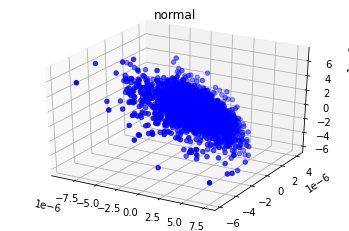

In [23]:
ax = plt.subplot(1,1,1, projection = '3d')
ax.scatter(normal_xx,normal_yy,normal_zz, c = 'b')
ax.set_title('normal')
plt.show()

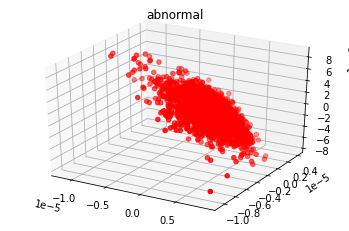

In [24]:
ax = plt.subplot(1,1,1, projection = '3d')
ax.scatter(abnormal_xx,abnormal_yy,abnormal_zz, c = 'r')
ax.set_title('abnormal')
plt.show()